In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.afw.display as afwDisplay
import lsst.afw.table

from kuaizi.display import display_single
from astropy.io import fits
from astropy.table import Table, hstack

import sys
sys.path.append('/home/jiaxuanl/Research/Merian/lambo/scripts/')

In [2]:
# Load Merian catalog as reference
filt = 'N708'
# filt = 'N540'
tract = 9813
patch = 61 # 68
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)

refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

refCatInBand = butler.get(
    'objectTable',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

expID = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1')

In [223]:
def moments_to_shape(xx, xy, yy):
    '''
    Based on Song Huang's unagi code: 
    https://github.com/dr-guangtou/unagi/blob/66d6107f7d5118581e30040916f303c860a216e2/unagi/catalog.py#L60
    with significant modification. His definition for radius was wrong.
    '''
    # Two elliptcities, see https://arxiv.org/pdf/1203.6833.pdf
    e1 = (xx - yy) / (xx + yy)
    e2 = (2.0 * xy / (xx + yy))
#     print(e1, e2)

    # Get the r50 or determinant radius, defined as 
    # 4th root of the determinant of the quadrupole matrix.
    # see http://doxygen.lsst.codes/stack/doxygen/x_mainDoxyDoc/classlsst_1_1pipe_1_1tasks_1_1functors_1_1_radius_from_quadrupole.html
    r_det = (xx * yy - xy**2)**(1/4)
    # we also compute trace radius, defined as (0.5 * (xx + yy))**(1/2)
    r_trc = (0.5 * (xx + yy))**(1/2)

    # Ellipticity or axis ratio
    ell = np.sqrt(e1 ** 2.0 + e2 ** 2.0)
    axis_ratio = np.sqrt((1 - ell) / (1 + ell)) # axis ratio
    # This ell = \frac{a^2 - b^2}{a^2 + b^2}, see https://arxiv.org/pdf/1203.6833.pdf

    # Position angle in degree or radian
    theta = (-0.5 * np.arctan2(e2, e1))
    theta = np.rad2deg(theta)
    
    return r_det, r_trc, axis_ratio, theta

def shape_to_ellipse(x, y, r, q, theta):
    """
    For display purpose. 
    Convert parameters to Matplotlib Ellipse patch.
    
    r is determinant radius. q is the axis ratio b/a. theta is the PA.
    """
    from matplotlib.patches import Ellipse
    a = r / np.sqrt(q) * 2 # semi-major axis
    b = a * q
    
    ell = Ellipse(xy=(x, y),
                    width=a,
                    height=b,
                    angle=180-theta, facecolor='None')
    return ell

In [236]:
# only select objects with good shape measurement
cat = refCatInBand[(refCatInBand['patch'] == patch)]
cat = cat[~cat['shape_flag']] 

In [237]:
len(cat)

14071

In [238]:
# Write sizes and shapes to the catalog
cat['N708_Rdet'], cat['N708_Rtrc'], cat['N708_q'], cat['N708_PA'] = moments_to_shape(cat['N708_ixx'].values, 
                                                                                     cat['N708_ixy'].values, 
                                                                                     cat['N708_iyy'].values)

cat['N540_Rdet'], cat['N540_Rtrc'], cat['N540_q'], cat['N540_PA'] = moments_to_shape(cat['N540_ixx'].values, 
                                                                                     cat['N540_ixy'].values, 
                                                                                     cat['N540_iyy'].values)

### Select some large bright objects for visualization

In [239]:
flag = (cat['N708_Rdet'] > 5) & (cat['N708_q'] < 0.5)
flag &= ((27 - 2.5 * np.log10(cat['N708_gaap1p0Flux'].values) < 18))

In [240]:
np.where(flag)

(array([  858,  1440,  1569,  2361,  2364,  2585,  2777,  4377,  4380,
         7234,  7651,  8884,  9167, 11769, 11790, 12531, 13120, 13653]),)

In [253]:
obj = cat.iloc[11790]

In [254]:
obj.name

3496068744327763949

In [255]:
obj['N708_bdReB'], obj['N708_bdReD']

(24.906271049477773, 8.509211506244442)

In [256]:
obj['N708_bdFluxB'], obj['N708_bdFluxD']

(208246.19038662603, 106790.18788470887)

In [257]:
r_det, r_trc, q, theta = moments_to_shape(obj['N708_ixx'], obj['N708_ixy'], obj['N708_iyy'])
r_det, r_trc, q, theta

(7.208322525024413, 8.725368132541206, 0.3943046446644109, -34.201662545969555)

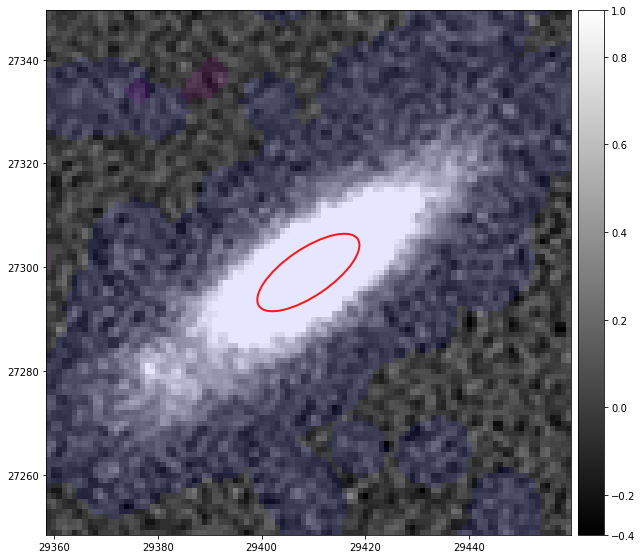

In [258]:
import lsst.geom as geom
import lsst.afw.display as afwDisplay
# pix = geom.Point2I((28827.530599686361, 26366.649353295288))
pix = geom.Point2I(obj['x'], obj['y'])
# Define a bounding box for the cutout region
bbox = geom.Box2I(pix, pix)
bbox.grow(50)

cutout = refExposure[bbox]

afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")

# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('NO_DATA', 'cyan')
# display.setMaskPlaneColor('DETECTED', 'blue')

display.setMaskTransparency(90)
display.mtv(cutout)

# e = shape_to_ellipse(pix.getX(), pix.getY(), obj[f'{filt}_Rdet'], obj[f'{filt}_q'], obj[f'{filt}_PA'])
e = shape_to_ellipse(pix.getX(), pix.getY(), r_det, q, theta)
ax.add_artist(e)
e.set_alpha(0.9)
e.set_facecolor('None')
e.set_edgecolor('r')
e.set_linewidth(2.0)

In [39]:
obj[f'{filt}_Rdet'].dtype

dtype('float64')

In [37]:
pix.getX(), pix.getY(), obj[f'{filt}_Rdet'], obj[f'{filt}_q'], obj[f'{filt}_PA']

(30766, 26422, 6.20355987548828, 0.7108533592270737, 10.642839718827487)

In [ ]:
# Write sizes and shapes to the catalog
cat['N708_Rdet'], cat['N708_Rtrc'], cat['N708_q'], cat['N708_PA'] = moments_to_shape(cat['N708_ixx'].values, 
                                                                                     cat['N708_ixy'].values, 
                                                                                     cat['N708_iyy'].values)


ixx shape in ObjectTable comes from deepCoadd_obj -- meas -- slot_Shape_xx.

---

In [260]:
filt = 'N708'
# filt = 'N540'
tract = 9813
patch = 61
patch_old = f'{patch % 9},{patch // 9}'

refCatObj = butler.get(
    'deepCoadd_obj',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [261]:
cat = refCatObj['meas'][filt]
new_cat = Table(data=[cat.index.values], names=['id'])
new_cat['coord_ra'] = np.rad2deg(cat['coord_ra'].values)
new_cat['coord_dec'] = np.rad2deg(cat['coord_dec'].values)
new_cat['x'] = cat['base_SdssCentroid_x'].values
new_cat['y'] = cat['base_SdssCentroid_y'].values


name = 'base_SdssShape'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_Sdss'] = r_det
new_cat[f'{filt}_q_Sdss'] = q
new_cat[f'{filt}_PA_Sdss'] = theta


name = 'modelfit_CModel_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel'] = r_det
new_cat[f'{filt}_q_CModel'] = q
new_cat[f'{filt}_PA_CModel'] = theta


name = 'modelfit_CModel_exp_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel_exp'] = r_det
new_cat[f'{filt}_q_CModel_exp'] = q
new_cat[f'{filt}_PA_CModel_exp'] = theta


name = 'modelfit_CModel_dev_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel_dev'] = r_det
new_cat[f'{filt}_q_CModel_dev'] = q
new_cat[f'{filt}_PA_CModel_dev'] = theta

In [262]:
# np.where(new_cat['id'] == 3496068744327763949)

In [265]:
# obj = new_cat[30961]
# obj = new_cat[21992]
obj = new_cat[26916]

(29409, 27299)


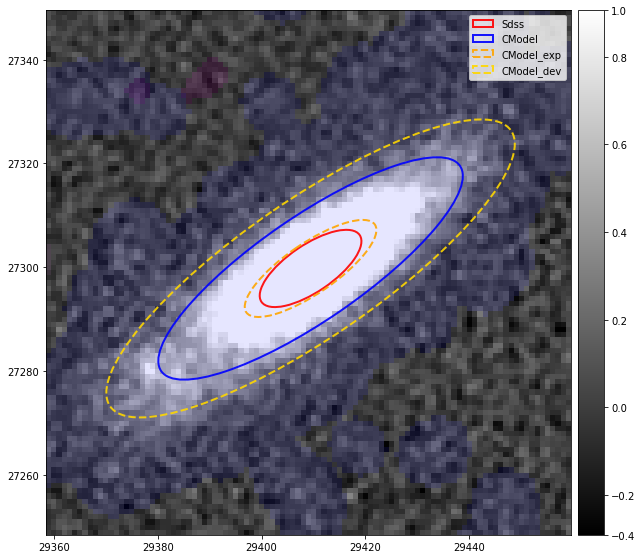

In [282]:
import lsst.geom as geom
import lsst.afw.display as afwDisplay

pix = geom.Point2I(obj['x'], obj['y'])
print(pix)
# Define a bounding box for the cutout region
bbox = geom.Box2I(pix, pix)
bbox.grow(50)

cutout = refExposure[bbox]

afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")

# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('NO_DATA', 'cyan')
# display.setMaskPlaneColor('DETECTED', 'blue')

display.setMaskTransparency(90)

display.mtv(cutout)

for c, name in zip(['r', 'b'], ['Sdss', 'CModel']):
    e = shape_to_ellipse(obj['x'], obj['y'], 
                         obj[f'{filt}_Re_{name}'], obj[f'{filt}_q_{name}'], obj[f'{filt}_PA_{name}'])
    ax.add_artist(e)
    e.set_alpha(0.9)
    e.set_facecolor('None')
    e.set_edgecolor(c)
    e.set_linewidth(2.0)
    e.set_label(name)
    
for c, name in zip(['orange', 'gold'], ['CModel_exp', 'CModel_dev']):
    e = shape_to_ellipse(obj['x'], obj['y'], 
                         obj[f'{filt}_Re_{name}'], obj[f'{filt}_q_{name}'], obj[f'{filt}_PA_{name}'])
    ax.add_artist(e)
    e.set_alpha(0.9)
    e.set_facecolor('None')
    e.set_edgecolor(c)
    e.set_linestyle('--')
    e.set_linewidth(2.0)
    e.set_label(name)

plt.legend()

In [167]:
obj = cat.iloc[21992]

In [168]:
name = 'base_SdssShape'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
r_det, r_trc, q, theta 

(6.197135502988656, 6.376115057120251, 0.7112839064943878, 10.44251142918972)

In [169]:
name = 'modelfit_CModel_ellipse'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
r_det, r_trc, q, theta 

(6.975449207529935, 7.262694877936174, 0.6655159034109608, 10.159751543989136)

In [170]:
name = 'modelfit_CModel_dev_ellipse'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
r_det, r_trc, q, theta 

(19.51238086078937, 20.428131359571445, 0.6473335228936037, 9.50659514607466)

In [171]:
name = 'modelfit_CModel_exp_ellipse'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
r_det, r_trc, q, theta 

(6.975449207529935, 7.262694877936174, 0.6655159034109608, 10.159751543989136)

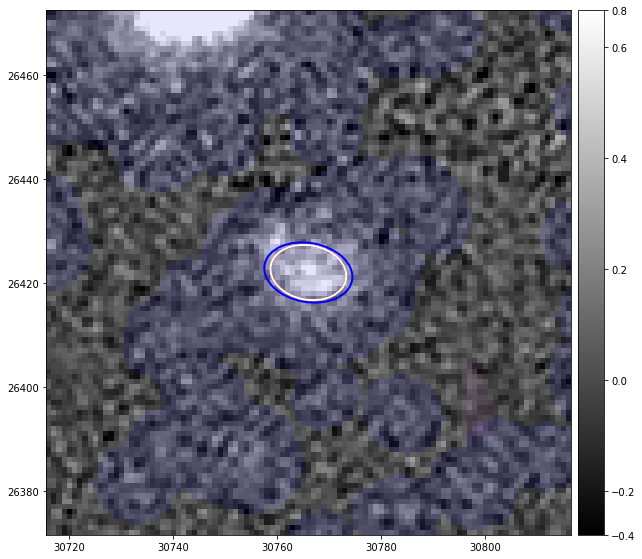

In [172]:
import lsst.geom as geom
import lsst.afw.display as afwDisplay
# pix = geom.Point2I(obj['x'], obj['y'])

pix = geom.Point2I(obj['base_SdssCentroid_x'], obj['base_SdssCentroid_y'])
# Define a bounding box for the cutout region
bbox = geom.Box2I(pix, pix)
bbox.grow(50)

cutout = refExposure[bbox]

afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")

# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('NO_DATA', 'cyan')
# display.setMaskPlaneColor('DETECTED', 'blue')

display.setMaskTransparency(90)
display.mtv(cutout)

name = 'base_SdssShape'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
e = shape_to_ellipse(pix.getX(), pix.getY(), r_det, q, theta)
ax.add_artist(e)
e.set_edgecolor('r')
e.set_linewidth(2.0)


# name = 'modelfit_CModel_exp_ellipse'
name = 'modelfit_CModel_ellipse'
r_det, r_trc, q, theta = moments_to_shape(obj[f'{name}_xx'], obj[f'{name}_xy'], obj[f'{name}_yy'])
e = shape_to_ellipse(pix.getX(), pix.getY(), r_det, q, theta)
ax.add_artist(e)
e.set_edgecolor('b')
e.set_linewidth(2.0)


obj = refCatInBand.iloc[21992]
r_det, r_trc, q, theta = moments_to_shape(obj[f'N708_ixx'], obj[f'N708_ixy'], obj[f'N708_iyy'])
e = shape_to_ellipse(pix.getX(), pix.getY(), r_det, q, theta)
ax.add_artist(e)
e.set_edgecolor('w')
e.set_linewidth(2.0)

In [149]:
obj = refCatInBand.iloc[21992]
obj['N708_bdE1'], obj['N708_bdE2']

#obj['N708_bdReB'], obj['N708_bdReD']

(71.52528327990531, -0.13407041330282937)

In [152]:
obj = refCatInBand.iloc[21992]
obj['N540_bdE1'], obj['N540_bdE2']

(90.6825500156659, -0.17520121459470456)

In [30]:
(obj['modelfit_CModel_ellipse_xx'] - obj['modelfit_CModel_ellipse_yy']) / (obj['modelfit_CModel_ellipse_xx'] + obj['modelfit_CModel_ellipse_yy'])

0.18725953225229472

In [34]:
(2 * obj['modelfit_CModel_ellipse_xy']) / (obj['modelfit_CModel_ellipse_xx'] + obj['modelfit_CModel_ellipse_yy'])

-0.3415509575187889

In [33]:
# list(refCat['meas']['N708'].keys())

Calculate :math:`e_1` ellipticity component for sources, defined as:

.. math::
    e_1 &= (I_{xx}-I_{yy})/(I_{xx}+I_{yy})

In [42]:
obj = refCatInBand.iloc[111]

In [43]:
obj['coord_ra'], obj['coord_dec']

(149.73862901004097, 2.5094386311639534)

In [23]:
(obj['N708_ixx'] - obj['N708_iyy']) / (obj['N708_ixx'] + obj['N708_iyy'])

nan

In [24]:
(2 * obj['N708_ixy']) / (obj['N708_ixx'] + obj['N708_iyy'])

nan

In [25]:
obj['N708_bdE1']

13.315776179303928